In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Fri Oct  7 10:50:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow
print(tensorflow.__version__)

2.8.2


In [3]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np


# Data processing

In [4]:
(xtn, ytn), (xtt, ytt) = K.datasets.cifar10.load_data()
print(xtn.shape, ytn.shape, xtt.shape, ytt.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
def preprocess_data(X, Y):
  x = K.applications.densenet.preprocess_input(X)
  y = K.utils.to_categorical(Y, 10)
  return x, y

In [6]:
xtn, ytn = preprocess_data(xtn, ytn)
xtt, ytt = preprocess_data(xtt, ytt)

print(xtn[0].shape, ytn[0].shape)

(32, 32, 3) (10,)


# Transfer Learning

In [7]:
base_model = K.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        pooling='avg',
                                        input_shape=(224, 224, 3))
base_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [8]:
inputs = K.Input(shape=(32, 32, 3))
input = K.layers.Lambda(lambda image : tf.image.resize(image, (224, 224)))(inputs)

x = base_model(input, training=False)

# x = K.layers.GlobalAveragePooling2D()(x)

x = K.layers.Dense(500, activation='relu')(x)
x = K.layers.Dropout(0.3)(x)
outputs = K.layers.Dense(10, activation='softmax')(x)

model = K.Model(inputs, outputs)

# Model with no trainable

In [9]:
base_model.trainable = False

optimizer = K.optimizers.Adam()

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
Total params: 7,555,014
Trainable params: 517,510
Non-trainab

In [10]:
history = model.fit(xtn,
                    ytn,
                    validation_data=(xtt, ytt),
                    batch_size=300,
                    epochs=4,
                    verbose=1)
model.save('/content/drive/MyDrive/Colab Notebooks/supervised_learning/tests for 0x09/cifar10_DenseN121.h5')

Epoch 1/4
167/167 [==============================] - 46s 185ms/step - loss: 0.5146 - acc: 0.8235 - val_loss: 0.3432 - val_acc: 0.8853
Epoch 2/4
167/167 [==============================] - 27s 161ms/step - loss: 0.3343 - acc: 0.8856 - val_loss: 0.3102 - val_acc: 0.8942
Epoch 3/4
167/167 [==============================] - 27s 161ms/step - loss: 0.2965 - acc: 0.8989 - val_loss: 0.3044 - val_acc: 0.8954
Epoch 4/4
167/167 [==============================] - 27s 161ms/step - loss: 0.2747 - acc: 0.9051 - val_loss: 0.2912 - val_acc: 0.8997


# Fine tunning

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787271 to fit



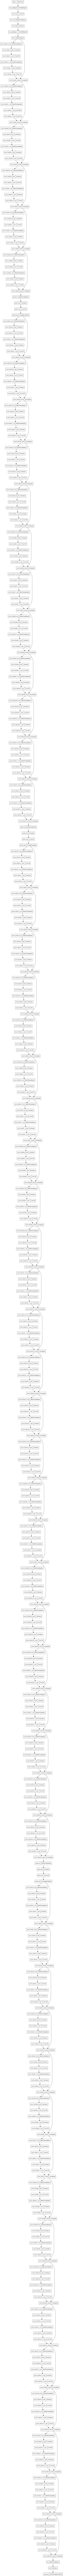

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='/content/drive/MyDrive/Colab Notebooks/supervised_learning/tests for 0x09/model_Dens121.png')

In [12]:
for i, layer in enumerate(base_model.layers):
  print(i, '-', layer.name)

0 - input_1
1 - zero_padding2d
2 - conv1/conv
3 - conv1/bn
4 - conv1/relu
5 - zero_padding2d_1
6 - pool1
7 - conv2_block1_0_bn
8 - conv2_block1_0_relu
9 - conv2_block1_1_conv
10 - conv2_block1_1_bn
11 - conv2_block1_1_relu
12 - conv2_block1_2_conv
13 - conv2_block1_concat
14 - conv2_block2_0_bn
15 - conv2_block2_0_relu
16 - conv2_block2_1_conv
17 - conv2_block2_1_bn
18 - conv2_block2_1_relu
19 - conv2_block2_2_conv
20 - conv2_block2_concat
21 - conv2_block3_0_bn
22 - conv2_block3_0_relu
23 - conv2_block3_1_conv
24 - conv2_block3_1_bn
25 - conv2_block3_1_relu
26 - conv2_block3_2_conv
27 - conv2_block3_concat
28 - conv2_block4_0_bn
29 - conv2_block4_0_relu
30 - conv2_block4_1_conv
31 - conv2_block4_1_bn
32 - conv2_block4_1_relu
33 - conv2_block4_2_conv
34 - conv2_block4_concat
35 - conv2_block5_0_bn
36 - conv2_block5_0_relu
37 - conv2_block5_1_conv
38 - conv2_block5_1_bn
39 - conv2_block5_1_relu
40 - conv2_block5_2_conv
41 - conv2_block5_concat
42 - conv2_block6_0_bn
43 - conv2_block6_0_

In [13]:
for layer in base_model.layers[:141]:
  layer.trainable=False
for layer in base_model.layers[141:]:
  layer.trainable=True

In [14]:
optimizer = K.optimizers.Adam(1e-5)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
history = model.fit(xtn,
                    ytn,
                    validation_data=(xtt, ytt),
                    batch_size=300,
                    epochs=4,
                    verbose=1)
model.save('/content/drive/MyDrive/Colab Notebooks/supervised_learning/tests for 0x09/cifar10_DenseN121.h5')

Epoch 1/4
167/167 [==============================] - 34s 171ms/step - loss: 0.2361 - acc: 0.9187 - val_loss: 0.2835 - val_acc: 0.9031
Epoch 2/4
167/167 [==============================] - 27s 160ms/step - loss: 0.2306 - acc: 0.9215 - val_loss: 0.2821 - val_acc: 0.9042
Epoch 3/4
167/167 [==============================] - 27s 160ms/step - loss: 0.2283 - acc: 0.9228 - val_loss: 0.2811 - val_acc: 0.9043
Epoch 4/4
167/167 [==============================] - 27s 160ms/step - loss: 0.2250 - acc: 0.9232 - val_loss: 0.2803 - val_acc: 0.9040
